In [1]:
import sys # for automation and parallelization: set manual to false when run by a launcher
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])

# START

In [2]:
import sys
sys.path.insert(0, r'../../../quetzal')

from quetzal.model import stepmodel

import numpy as np
import pandas as pd

PyTables is not installed. No support for HDF output.


In [3]:
training_folder = '../../'

In [4]:
sm = stepmodel.read_zippedpickles(training_folder + 'models/{scen}/aon_pathfinder'.format(scen=scenario))

zone_to_transit: 100%|██████████| 31/31 [00:01<00:00, 18.96it/s]          


# generation
- Production = Population
- Attraction = Jobs

In [5]:
sm.zones['emission'] =  sm.zones['pop'].astype(int) / 10 # peak hour generation
sm.zones['attraction'] =  sm.zones['emp'].astype(int) / 10
sm.zones['pop'].sum()

2158238.2271273527

# car owners
car owners distribution is based on car times

In [6]:
motor_rate = 0.3
car = sm.copy()
car.zones['emission'] *= motor_rate

In [7]:
imp_matrix = car.car_los[
    ['origin', 'destination', 'time']
].set_index(['origin','destination']).unstack() 
imp_matrix = imp_matrix.replace(0, 120)

car.step_distribution(deterrence_matrix=imp_matrix)

# PT captives
car owners distribution is based on car times

In [8]:
pt = sm.copy()
pt.zones['emission'] *= (1-motor_rate)

In [9]:
# Ici on prend comme fonction de coût le temps TC. Notez le .unstack() 
imp_matrix = pt.pt_los[
    ['origin', 'destination', 'gtime']
].set_index(['origin','destination']).unstack() 
imp_matrix = imp_matrix.replace(0, 120)

In [10]:
imp_matrix

gtime                                                      \
destination       zone_0       zone_1      zone_10     zone_100     zone_101   
origin                                                                         
zone_0        120.000000   647.986131   931.651550  1787.997613  2050.550044   
zone_1        647.986131   120.000000  1303.293199  1855.139662  2103.384306   
zone_10       991.651550  1341.442949   120.000000  1849.745726  2076.596863   
zone_100     1787.997613  1805.169336  1789.745726   120.000000  1348.644220   
zone_101     2080.550044  2076.087652  2076.596863  1408.644220   120.000000   
...                  ...          ...          ...          ...          ...   
zone_95      1602.168702  1497.674531  1659.376355   901.423712  1007.504733   
zone_96      1890.759158  1907.930881  2064.186301   856.233658  1602.886570   
zone_97      1774.188828  1913.980227  1770.235647   782.822966  1149.134142   
zone_98      2127.561499  2231.906494  2123.608318   915.655675  1443.185117   
zone_99      1698.947201  1770.588850  2030.669125  1312.773488   914.153204   

                                                                              \
destination     zone_102     zone_103     zone_104     zone_105     zone_106   
origin                                                                         
zone_0       1856.094447  1902.032755  1903.287122  1645.035114  1739.127328   
zone_1       1923.236496  1951.824154  1970.429171  1712.177163  1806.269377   
zone_10      2010.750365  2108.079574  2106.714265  1848.462257  1902.336433   
zone_100     1773.247977  1230.126931  1041.479912   872.188644  1866.280859   
zone_101     2320.306012  1839.276912  2039.675251  1857.360752  2419.228446   
...                  ...          ...          ...          ...          ...   
zone_95      1932.428351  1549.757560  1548.392252  1350.140243  2069.709095   
zone_96      1697.713890   802.885415   844.906566  1124.950189  1553.934264   
zone_97      1987.491500  1454.163556  1452.798248  1254.546239  2184.115091   
zone_98      1965.723293  1174.281277  1442.915968  1364.372206  1754.232811   
zone_99      2343.778127  1875.272775  1959.742028  1761.490020  2455.224309   

             ...                                                      \
destination  ...      zone_90      zone_91      zone_92      zone_93   
origin       ...                                                       
zone_0       ...  1865.987418  1876.710344  1927.768527  2101.883660   
zone_1       ...  1995.749143  1923.882067  1914.940250  2151.675059   
zone_10      ...  2111.273233  1974.992637  1981.195670  2217.930479   
zone_100     ...  1968.465440  1758.034769  1643.243027  1849.977836   
zone_101     ...  2261.885009  2194.885907  1858.392609  1635.937822   
...          ...          ...          ...          ...          ...   
zone_95      ...  1898.096070  1761.815474  1422.873656  1223.946350   
zone_96      ...  2242.906016  2032.475344  1917.683602  2124.418411   
zone_97      ...  2072.502066  1862.071394  1747.279652  1710.467757   
zone_98      ...  2302.328033  2091.897361  1977.105619  2131.741185   
zone_99      ...  1929.793164  1847.286332  1526.300764  1025.079323   

                                                                              \
destination      zone_94      zone_95      zone_96      zone_97      zone_98   
origin                                                                         
zone_0       1701.156036  1710.205973  1802.463526  1744.188828  2220.181175   
zone_1       1690.947435  1693.008457  1869.605575  1961.179060  2287.323224   
zone_10      1787.202855  1857.413627  2005.890669  1770.235647  2326.346008   
zone_100     1089.250212  1159.460984   916.233658   782.822966  1169.861892   
zone_101     1095.217813   947.504733  1594.798862  1149.134142  1435.097409   
...                  ...          ...          ...          ...          ...   
zone_95       628.880841   120.000000  1235.8642

In [11]:
pt.step_distribution(deterrence_matrix=imp_matrix)

In [12]:
pt.volumes

,origin,destination,volume
0,zone_0,zone_0,0.009516
1,zone_0,zone_1,0.317718
2,zone_0,zone_2,0.257795
3,zone_0,zone_3,0.443399
4,zone_0,zone_4,0.418649
...,...,...,...
12095,zone_109,zone_105,1.389062
12096,zone_109,zone_106,7.249143
12097,zone_109,zone_107,4.757378
12098,zone_109,zone_108,3.917599


# merge matrices

In [13]:
sm.volumes = pd.merge(
    car.volumes,
    pt.volumes,
    on=['origin', 'destination'],
    suffixes=[ '_car_owner', '_pt_captive']
).rename(columns={'volume_car_owner': 'car_owner', 'volume_pt_captive': 'pt_captive'})

# to_zip

In [14]:
sm.to_zippedpickles(
    training_folder + 'models/{scen}/distribution'.format(scen=scenario), 
    only_attributes=['volumes', 'epsg', 'coordinates_unit']
)

volumes: 100%|██████████| 32/32 [00:00<00:00, 758.90it/s]


# monitoring

Text(0.5, 1.0, 'PT captives distribution')

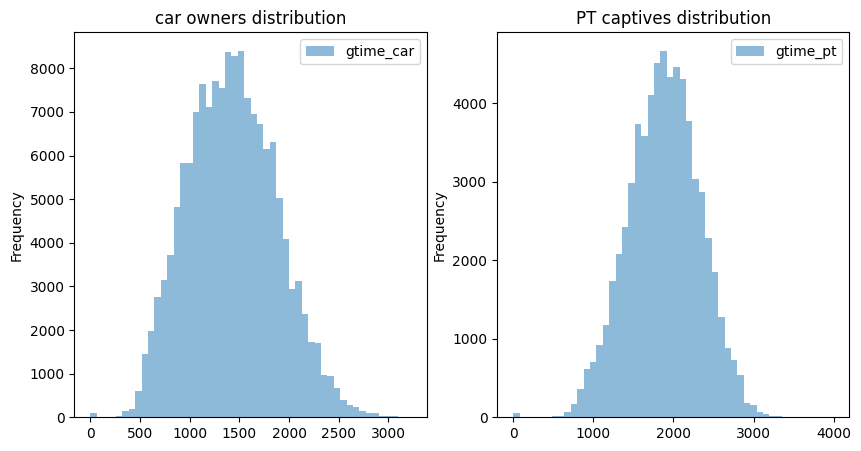

In [15]:
od = pd.merge(sm.volumes, sm.pt_los, on=['origin', 'destination'])
od = pd.merge(od, sm.car_los, on=['origin', 'destination'], suffixes=['_pt', '_car'])
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=[10, 5])
plot = od[['gtime_car']].plot(kind='hist', weights=od['pt_captive'], bins=50, alpha=0.5, ax=axes[0])
plot.set_title('car owners distribution')
plot = od[['gtime_pt']].plot(kind='hist', weights=od['car_owner'], bins=50, alpha=0.5, ax=axes[1])
plot.set_title('PT captives distribution')

# END